<a href="https://colab.research.google.com/github/LastChanceKatze/image-caption-gen/blob/main/img_caption_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Imports***

In [3]:
from os import listdir
import string
from pickle import dump, load
import tensorflow.keras.applications.vgg16 as vgg16
import tensorflow.keras.applications.inception_v3 as inception_v3
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras_preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import concatenate
from keras.callbacks import ModelCheckpoint, CSVLogger
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
drive_folder = "/content/drive/MyDrive/DL"
vgg_img_features_path = f"{drive_folder}/training_files/img_features.pkl"
inc_img_features_path = f"{drive_folder}/training_files/img_features_inc_v3.pkl"
img_train_path = f"{drive_folder}/Dataset/Flickr8k_text/Flickr_8k.trainImages.txt"
img_test_path = f"{drive_folder}/Dataset/Flickr8k_text/Flickr_8k.devImages.txt"
captions_filename = f"{drive_folder}/training_files/captions.txt"
glove_path = f"{drive_folder}/glove/glove.txt"

# ***Preprocessing***

### *Preprocess captions*

In [ ]:
def load_captions(filename):
    """
    Load captions from file and create a per image caption dictionary
    :param filename:
    :return:
    """
    # read from the captions file
    file = open(filename, "r")
    text = file.read()
    file.close()

    mapping = dict()

    # process each line
    # line is in form: image_name.jpg#no caption
    for line in text.split("\n"):
        token = line.split("\t")

        if len(line) < 2:
            continue

        # first token: image id
        # rest: image caption
        img_id, img_capt = token[0], token[1:]
        # extract image id: before the .jpg part
        img_id = img_id.split('.')[0]
        # convert caption list back to string
        img_capt = ' '.join(img_capt)

        # add all the captions od the same image to image_id key
        if img_id not in mapping:
            mapping[img_id] = list()
        mapping[img_id].append(img_capt)

    return mapping


def clean_captions(captions):
    """
    Remove punctuation, hanging s and a, and tokens with numbers
    from the captions
    :param captions:
    :return:
    """
    # Prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for _, caption_list in captions.items():
        for i in range(len(caption_list)):
            caption = caption_list[i]
            # Tokenize i.e. split on white spaces
            caption = caption.split()
            # Convert to lowercase
            caption = [word.lower() for word in caption]
            # Remove punctuation from each token
            caption = [w.translate(table) for w in caption]
            # Remove hanging 's' and 'a'
            caption = [word for word in caption if len(word)>1]
            # Remove tokens with numbers in them
            caption = [word for word in caption if word.isalpha()]
            # Store as string
            caption_list[i] = ' '.join(caption)


def save_captions(captions_dict, to_file):
    """
    Save the captions_dict to a file,
    file: image_id caption_list per line
    :param captions_dict:
    :param to_file:
    :return:
    """
    # convert captions dictionary to string of lines
    lines = list()
    for key, caption_list in captions_dict.items():
        for caption in caption_list:
            lines.append(key + ' ' + caption)
    data = '\n'.join(lines)

    # save captions string to a file
    file = open(to_file, 'w')
    file.write(data)
    file.close()


def preprocess_captions(capt_filename=f"{drive_folder}/Dataset/Flickr8k_text/Flickr8k.token.txt",
                        clean_capt_to_file=f"{drive_folder}/training_files/captions.txt"):
    captions_dict = load_captions(capt_filename)
    clean_captions(captions_dict)
    save_captions(captions_dict, clean_capt_to_file)

In [ ]:
preprocess_captions()

### *Extract image features*

In [ ]:
def create_cnn_model_dict():
  cnn_model_dict = dict()

  cnn_model_dict['vgg16'] = {
      'model': vgg16.VGG16(),
      'target_size': (224, 224),
      'preprocess_input': vgg16.preprocess_input
  }

  cnn_model_dict['inception_v3'] = {
      'model': inception_v3.InceptionV3(),
      'target_size': (299, 299),
      'preprocess_input': inception_v3.preprocess_input
  }
  return cnn_model_dict

In [ ]:
def extract_features(images_dir, model_type, cnn_model_dict):
    model = cnn_model_dict[model_type]['model']
    target_size = cnn_model_dict[model_type]['target_size']
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    model.summary()

    features_dict = dict()

    img_count = 0

    for name in listdir(images_dir):
      filename = f"{images_dir}/{name}"
      image = load_img(filename, target_size=target_size)
      image = img_to_array(image)
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      image = cnn_model_dict[model_type]['preprocess_input'](image)
      features = model.predict(image, verbose=0)
      image_id = name.split('.')[0]
      features_dict[image_id] = features
      
      img_count += 1

      if img_count % 200 == 0:
        print("No. images", img_count)
        print()

      print(".", end="")

    return features_dict

def save_img_features(img_features, to_file):
  dump(img_features, open(to_file, "wb"))

def preprocess_img_features(images_dir=f"{drive_folder}/Dataset/Flickr8k_Dataset/Flicker8k_Dataset",
                            to_file=f"{drive_folder}/training_files/img_features.pkl",
                            model_type):
  cnn_model_dict = create_cnn_model_dict()
  features = extract_features(images_dir, model_type, cnn_model_dict)
  print("No. features", len(features))
  save_img_features(features, to_file)

In [ ]:
preprocess_img_features(to_file=f"{drive_folder}/training_files/img_features_inc_v3.pkl")

# ***Load preprocessed data***

In [6]:
def load_img_ids(filename):
    """
    Load image ids from a file
    """
    file = open(filename, "r")
    text = file.read()
    file.close()

    img_ids = list()
    for line in text.split("\n"):

        if len(line) < 1:
            continue

        img_id = line.split('.')[0]
        img_ids.append(img_id)

    return img_ids

In [7]:
def load_img_features(img_features, train_ids, test_ids):
    """
    Load train and test features from a file
    :param img_features:
    :param train_ids:
    :param test_ids:
    :return:
    """
    features = load(open(img_features, "rb"))

    train_features = {train_id: features[train_id] for train_id in train_ids}
    test_features = {test_id: features[test_id] for test_id in test_ids}

    return train_features, test_features

def load_clean_captions(filename, dataset):
    """
    load captions from file and create entry for each imgId from dataset
    """
    file = open(filename, 'r')
    text = file.read()
    file.close()

    captions = dict()

    for line in text.split('\n'):

        tokens = line.split()
        img_id, img_caption = tokens[0], tokens[1:]

        if img_id in dataset:
            if img_id not in captions:
                captions[img_id] = list()

            # add startseq at the begining and endseq at the end of each caption
            caption = 'startseq ' + ' '.join(img_caption) + ' endseq'
            captions[img_id].append(caption)

    return captions

In [8]:
# NOT USED
def load_train_test(img_features_path, captions_path, train_ids_path, 
                    test_ids_path):
    """
    Load train image features and captions, load test image features and captions
    :param img_features_path:
    :param captions_path:
    :param train_ids_path:
    :param test_ids_path:
    :return:
    """
    img_train_ids = load_img_ids(img_train_path)
    img_test_ids = load_img_ids(img_test_path)

    train_features, test_features = load_img_features(img_features_path, img_train_ids, img_test_ids)


    train_captions = load_clean_captions(captions_filename, img_train_ids)
    test_captions = load_clean_captions(captions_filename, img_test_ids)

    print("Train images: ", len(train_features))
    print("Train captions: ", len(train_captions))
    print("Test images: ", len(test_features))
    print("Test captions: ", len(test_captions))

    return train_features, train_captions, test_features, test_captions


In [9]:
img_train_ids = load_img_ids(img_train_path)
img_test_ids = load_img_ids(img_test_path)

train_captions = load_clean_captions(captions_filename, img_train_ids)
test_captions = load_clean_captions(captions_filename, img_test_ids)

vgg_train_features, vgg_test_features = load_img_features(vgg_img_features_path, img_train_ids, img_test_ids)
inc_train_features, inc_test_features = load_img_features(inc_img_features_path, img_train_ids, img_test_ids)


In [10]:
print("Train images: ", len(vgg_train_features))
print("Train captions: ", len(train_captions))
print("Test images: ", len(vgg_test_features))
print("Test captions: ", len(test_captions))
print("VGG-16 feature vector:", len(vgg_train_features[img_train_ids[0]][0]))
print("Inception V3 feature vector:", len(inc_train_features[img_train_ids[0]][0]))

Train images:  6000
Train captions:  6000
Test images:  1000
Test captions:  1000
VGG-16 feature vector: 4096
Inception V3 feature vector: 2048


# ***Prepare data for model fitting***

In [11]:
def to_lines(captions):
    """
    Extract values from captions dictionary
    """
    all_captions = list()
    for key in captions.keys():
        [all_captions.append(d) for d in captions[key]]
    return all_captions


def create_tokenizer(captions):
    lines = to_lines(captions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


def calc_max_length(captions):
    lines = to_lines(captions)
    return max(len(line.split()) for line in lines)

In [12]:
tokenizer = create_tokenizer(train_captions)
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ", vocab_size)
max_length = calc_max_length(train_captions)
print("Max caption length: ", max_length)

Vocabulary size:  7579
Max caption length:  34


In [13]:
def create_sequences(image, caption_list, tokenizer, max_length, vocab_size):
    """
    Generate sequences from a caption, containing just the first word, first two words etc.
    For word i in sequence, separate the caption into input=caption[:i] and next_word=caption[i];
    encode each word as a categorical value.
    :param image:
    :param caption_list:
    :param tokenizer:
    :param max_length:
    :param vocab_size:
    :return:
    """
    in_img_list, in_word_list, out_word_list = list(), list(), list()
    for capt in caption_list:
        # tokenize each caption
        seq = tokenizer.texts_to_sequences([capt])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode word to a categorical value
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

            in_img_list.append(image)
            in_word_list.append(in_seq)
            out_word_list.append(out_seq)
    return in_img_list, in_word_list, out_word_list

In [14]:
def data_generator(images, captions, tokenizer, max_length, batch_size, random_seed, vocab_size):
    """
    Extract images, input word sequences and output word in batches. To be used while fitting the model.
    :param images:
    :param captions:
    :param tokenizer:
    :param max_length:
    :param batch_size:
    :param random_seed:
    :param vocab_size:
    :return:
    """
    random.seed(random_seed)

    img_ids = list(captions.keys())

    count = 0
    while True:
        if count >= len(img_ids):
            count = 0

        in_img_batch, in_seq_batch, out_word_batch = list(), list(), list()

        # get current batch indexes
        for i in range(count, min(len(img_ids), count+batch_size)):
            # current image_id
            img_id = img_ids[i]
            # current image
            img = images[img_id][0]
            # current image caption list
            captions_list = captions[img_id]
            # shuffle the captions
            random.shuffle(captions_list)
            # get word sequences and output word
            in_img, in_seq, out_word = create_sequences(img, captions_list, tokenizer, max_length, vocab_size)

            # append to batch list
            for j in range(len(in_img)):
                in_img_batch.append(in_img[j])
                in_seq_batch.append(in_seq[j])
                out_word_batch.append(out_word[j])

        count = count + batch_size
        yield [np.array(in_img_batch), np.array(in_seq_batch)], np.array(out_word_batch)

#***Glove embedding***

In [ ]:
def glove_embedding_indices(glove_filepath):
    """
    Mapira world embedding fajl u dictionary, za svaku rec u fajlu
     mapira njene relacije
    :param word_index:
    :param vocab_size:
    :return:
    """
    embeddings_index = {}

    glove = open(glove_filepath, 'r', encoding='utf-8').read()
    for line in glove.split("\n"):
        values = line.split(" ")
        word = values[0]
        indices = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = indices

    return embeddings_index

def get_vocab_embedding_weights(embeddings_index, word_index, vocab_size, emd_dim=200):
    """
    Kreira embedding matricu za reci koje
     se javljaju u vocab_index
    :param embeddings_index:
    :param word_index:
    :param vocab_size: 
    :return: 
    """
    #emb_dim = 200
    emb_matrix = np.zeros((vocab_size, emb_dim))
    for word, i in word_index.items():
        emb_vec = embeddings_index.get(word)
        if emb_vec is not None:
            emb_matrix[i] = emb_vec

    return emb_matrix

In [ ]:
 emb_dim = 200

 def get_embedding_weights():
    embedding_matrix = glove_embedding_indices(glove_path)
    embedding_matrix_weights = get_vocab_embedding_weights(embedding_matrix, tokenizer.word_index, vocab_size, emb_dim)
    return embedding_matrix_weights

embedding_weights = get_embedding_weights()

NameError: ignored

# ***Model definitions***

**Basic model - vgg16**

In [15]:
# define the captioning model
def define_model(vocab_size, max_length, params):	
  image_input = Input(shape=(params['input_dim'],))
  image_model_1 = Dropout(params['dropout_value'])(image_input)
  image_model = Dense(params['dense_units'], activation='relu')(image_model_1)

  caption_input = Input(shape=(max_length,))
	# mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs. E.g. it is an efficiency.
  
  caption_model_1 = Embedding(vocab_size, params['embedding_size'], mask_zero = True)(caption_input)

  caption_model_2 = Dropout(params['dropout_value'])(caption_model_1)
  caption_model = LSTM(params['lstm_units'])(caption_model_2)

	# Merging the models and creating a softmax classifier
  final_model_1 = concatenate([image_model, caption_model])
  final_model_2 = Dense(params['dense_units'], activation='relu')(final_model_1)
  final_model = Dense(vocab_size, activation='softmax')(final_model_2)

  model = Model(inputs=[image_input, caption_input], outputs=final_model)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # model.summary()

  return model

**Model with embedding weights - vgg16**

In [16]:
# define the captioning model
def define_glove_model(vocab_size, max_length, params):	
  image_input = Input(shape=(params['input_dim'],))
  image_model_1 = Dropout(params['dropout_value'])(image_input)
  image_model = Dense(params['dense_units'], activation='relu')(image_model_1)

  caption_input = Input(shape=(max_length,))
	# mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs. E.g. it is an efficiency.
  
  caption_model_1 = Embedding(vocab_size, emb_dim, mask_zero = True)(caption_input)

  caption_model_2 = Dropout(params['dropout_value'])(caption_model_1)
  caption_model = LSTM(params['lstm_units'])(caption_model_2)

	# Merging the models and creating a softmax classifier
  final_model_1 = concatenate([image_model, caption_model])
  final_model_2 = Dense(params['dense_units'], activation='relu')(final_model_1)
  final_model = Dense(vocab_size, activation='softmax')(final_model_2)

  model = Model(inputs=[image_input, caption_input], outputs=final_model)

  model.layers[2].set_weights([embedding_weights])
  model.layers[2].trainable = False

  model.compile(loss='categorical_crossentropy', optimizer='adam')
  # model.summary()

  return model

In [17]:
def train_model(params):
  train_steps = len(params['train_captions']) // params['batch_size'] 
  if len(params['train_captions']) % params['batch_size']  != 0:
    train_steps = train_steps + 1

  test_steps = len(params['test_captions']) // params['batch_size']
  if len(params['test_captions']) % params['batch_size'] != 0:
    test_steps = test_steps + 1

  checkpoint = ModelCheckpoint(params['filepath'], monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  logger = CSVLogger(params['logger'])

  train_generator = data_generator(params['train_features'], params['train_captions'], params['tokenizer'], params['max_length'], params['batch_size'], 10, params['vocab_size'])
  test_generator = data_generator(params['test_features'], params['test_captions'], params['tokenizer'], params['max_length'], params['batch_size'], 10, params['vocab_size'])

  model = params['model']
  history = model.fit(train_generator, epochs = params['epochs'], steps_per_epoch = train_steps,
            validation_data=test_generator, validation_steps = test_steps,
            callbacks=[checkpoint, logger], verbose=1)
  
  return model

In [18]:
def plot_history(log_filepath):
    df = pd.read_csv(log_filepath)
    plt.plot(df['loss'])
    plt.plot(df['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss through epochs')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [23]:
def index_to_word(word_index, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == word_index:
            return word
    return None


def generate_caption(model, tokenizer, image, max_length):
    in_caption = "startseq"

    for _ in range(max_length):
        seq = tokenizer.texts_to_sequences([in_caption])[0]

        seq = pad_sequences([seq], maxlen=max_length)

        pred = model.predict([image, seq], verbose=0)

        pred = np.argmax(pred)

        word = index_to_word(pred, tokenizer)

        if word is None:
            break

        in_caption += ' ' + word

        if word == 'endseq':
            break

    return in_caption


def evaluate_model(model, images, captions, tokenizer, max_lenght):
    test, predicted = list(), list()

    img_count = 0
    for key, caption_list in captions.items():
        pred = generate_caption(model, tokenizer, images[key], max_lenght)

        predicted.append(pred.split())
        test.append([capt.split() for capt in caption_list])

        img_count += 1

        if img_count % 200 == 0:
          print("No. images", img_count)
          print()

        print(".", end="")

    print()    
    print("BLEU-1 ", corpus_bleu(test, predicted, weights=(1.0, 0, 0, 0)))
    print("BLEU-2 ", corpus_bleu(test, predicted, weights=(.5, .5, 0, 0)))
    print("BLEU-3 ", corpus_bleu(test, predicted, weights=(.3, .3, .3, 0)))
    print("BLEU-4 ", corpus_bleu(test, predicted))

# ***Training the models***

## VGG

### VGG + 256 + Dropout(0.5)

In [ ]:
vgg_5_256_model_params = {
    'input_dim': 4096,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.5,
    'embedding_size': 256
    }
vgg_5_256_model = define_model(vocab_size, max_length, vgg_5_256_model_params)
vgg_5_256_train_params = {
    'model':vgg_5_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/vgg_0.5_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/vgg_0.5_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': vgg_train_features,
    'test_features': vgg_test_features
    }
train_model(vgg_5_256_train_params)

### VGG + 256 + Dropout(0.3) 

In [ ]:
vgg_3_256_model_params = {
    'input_dim': 4096,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.3,
    'embedding_size': 256
    }
vgg_3_256_model = define_model(vocab_size, max_length, vgg_3_256_model_params)
vgg_3_256_train_params = {
    'model':vgg_3_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/vgg_0.3_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/vgg_0.3_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': vgg_train_features,
    'test_features': vgg_test_features
    }
train_model(vgg_3_256_train_params)

### VGG + 128 + Dropout(0.3)

In [ ]:
vgg_3_128_model_params = {
    'input_dim': 4096,
    'dense_units': 128,
    'lstm_units': 128,
    'dropout_value':0.3,
    'embedding_size': 128
    }
vgg_3_128_model = define_model(vocab_size, max_length, vgg_3_128_model_params)
vgg_3_128_train_params = {
    'model':vgg_3_128_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/vgg_0.3_128/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/vgg_0.3_128/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': vgg_train_features,
    'test_features': vgg_test_features
    }
train_model(vgg_3_128_train_params)

## Inception V3

### Inception V3 + 256 + Dropout(0.5)

In [ ]:
inc_5_256_model_params = {
    'input_dim': 2048,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.5,
    'embedding_size': 256
     }
inc_5_256_model = define_model(vocab_size, max_length, inc_5_256_model_params)
inc_5_256_train_params = {
    'model':inc_5_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/inc_v3_0.5_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/inc_v3_0.5_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': inc_train_features,
    'test_features': inc_test_features
    }
train_model(inc_5_256_train_params)

### Inception V3 + 256 + Dropout(0.3)

In [ ]:
inc_3_256_model_params = {
    'input_dim': 2048,
    'dense_units': 256,
    'lstm_units': 256,
    'dropout_value':0.3,
    'embedding_size': 256
     }
inc_3_256_model = define_model(vocab_size, max_length, inc_3_256_model_params)
inc_3_256_train_params = {
    'model':inc_3_256_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/inc_v3_0.3_256/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/inc_v3_0.3_256/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': inc_train_features,
    'test_features': inc_test_features
    }
train_model(inc_3_256_train_params)

### Inception V3 + 128 + Dropout(0.3)

In [ ]:
inc_3_128_model_params = {
    'input_dim': 2048,
    'dense_units': 128,
    'lstm_units': 128,
    'dropout_value':0.3,
    'embedding_size': 128
     }
inc_3_128_model = define_model(vocab_size, max_length, inc_3_128_model_params)
inc_3_128_train_params = {
    'model':inc_3_128_model,
    'epochs': 20,
    'batch_size': 64,
    'train_captions': train_captions,
    'test_captions': test_captions,
    'filepath': drive_folder + "/model/inc_v3_0.3_128/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
    'logger':  f"{drive_folder}/model/inc_v3_0.3_128/training.log",
    'tokenizer': tokenizer,
    'max_length': max_length,    
    'vocab_size': vocab_size,
    'train_features': inc_train_features,
    'test_features': inc_test_features
    }
train_model(inc_3_128_train_params)

## VGG + GLOVE

In [ ]:
glove_models_path  = drive_folder + "/glove_model"

glove_models_vgg_path = glove_models_path + "/Vgg16"

vgg_dropout_03_path = glove_models_vgg_path + "/Dropout-0.3"

vgg_dropout_05_path = glove_models_vgg_path + "/Dropout-0.5"


### VGG16 + Glove + Dropout(0.3) + Dense(128)

In [ ]:
vgg_dropout_03_dense_128_path = vgg_dropout_03_path + "/dense-128"

In [ ]:
vgg_glove_3_128_model_params = {'dropout_value':0.3,
     'dense_units': 128,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_3_128_model = define_glove_model(vocab_size, max_length, vgg_glove_3_128_model_params)

vgg_glove_3_128_train_params = {'model':vgg_glove_3_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': drive_folder + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5",
     'logger':  vgg_dropout_03_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_3_128_train_params)

### VGG16 + Glove + Dropout(0.3) + Dense(256)

In [ ]:
vgg_dropout_03_dense_256_path = vgg_dropout_03_path + "/dense-256"

In [ ]:
vgg_glove_3_256_model_params = {'dropout_value':0.3,
     'dense_units': 256,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_3_256_model = define_glove_model(vocab_size, max_length, vgg_glove_3_256_model_params)

vgg_glove_3_256_train_params = {'model':vgg_glove_3_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_03_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger': vgg_dropout_03_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_3_256_train_params)

### VGG16 + Glove + Dropout(0.5) + Dense(128)

In [ ]:
vgg_dropout_05_dense_128_path = vgg_dropout_05_path + "/dense-128"

In [ ]:
vgg_glove_5_128_model_params = {'dropout_value':0.5,
     'dense_units': 128,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_5_128_model = define_glove_model(vocab_size, max_length, vgg_glove_5_128_model_params)

vgg_glove_5_128_train_params = {'model':vgg_glove_5_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_05_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger':  vgg_dropout_05_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_5_128_train_params)

### VGG16 + Glove + Dropout(0.5) + Dense(256)

In [ ]:
vgg_dropout_05_dense_256_path = vgg_dropout_05_path + "/dense-256"

In [ ]:
vgg_glove_5_256_model_params = {'dropout_value':0.5,
     'dense_units': 256,
     'input_dim': 4096,
     'lstm_units': 256
     }

vgg_glove_5_256_model = define_glove_model(vocab_size, max_length, vgg_glove_5_256_model_params)

vgg_glove_5_256_train_params = {'model':vgg_glove_5_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': vgg_dropout_05_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger':  vgg_dropout_05_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': vgg_train_features,
     'test_features': vgg_test_features
     }

train_model(vgg_glove_5_256_train_params)

##Inception V3 + Glove

In [ ]:
glove_models_inception_v3_path = glove_models_path + "/InceptionV3"

inc_dropout_03_path = glove_models_vgg_path + "/Dropout-0.3"

inc_dropout_05_path = glove_models_vgg_path + "/Dropout-0.5"

### Inception V3 + Glove + Dropout(0.3) + Dense(128)

In [ ]:
inc_dropout_03_dense_128_path = inc_dropout_03_path + "/dense-128"

In [ ]:
inc_glove_3_128_model_params = {'dropout_value':0.3,
     'dense_units': 128,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_3_128_model = define_glove_model(vocab_size, max_length, inc_glove_3_128_model_params)

inc_glove_3_128_train_params = {'model': inc_glove_3_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_03_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger':  inc_dropout_03_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(inc_glove_3_128_train_params)

### Inception V3 + Glove + Dropout(0.3) + Dense(256)

In [ ]:
inc_dropout_03_dense_256_path = inc_dropout_03_path + "/dense-256"

In [ ]:
inc_glove_3_256_model_params = {'dropout_value':0.3,
     'dense_units': 256,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_3_256_model = define_glove_model(vocab_size, max_length, inc_glove_3_256_model_params)

inc_glove_3_256_train_params = {'model':inc_glove_3_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_03_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger': inc_dropout_03_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(vgg_glove_3_256_train_params)

### Inception V3 + Glove + Dropout(0.5) + Dense(128)

In [ ]:
inc_dropout_05_dense_128_path = inc_dropout_05_path + "/dense-128"

In [ ]:
inc_glove_5_128_model_params = {'dropout_value':0.5,
     'dense_units': 128,
     'input_dim': 2048,
     'lstm_units': 256
     }

inc_glove_5_128_model = define_glove_model(vocab_size, max_length, inc_glove_5_128_model_params)

inc_glove_5_128_train_params = {'model':inc_glove_5_128_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_05_dense_128_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger':  inc_dropout_05_dense_128_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(inc_glove_5_128_train_params)

### Inception V3 + Glove + Dropout(0.5) + Dense(256)

In [ ]:
inc_dropout_05_dense_256_path = inc_dropout_05_path + "/dense-256"

In [ ]:
inc_glove_5_256_model_params = {'dropout_value':0.5,
     'dense_units': 256,
     'input_dim': 4096,
     'lstm_units': 256
     }

inc_glove_5_256_model = define_glove_model(vocab_size, max_length, inc_glove_5_256_model_params)

inc_glove_5_256_train_params = {'model':inc_glove_5_256_model,
     'epochs': 20,
     'batch_size': 64,
     'plot_hist': True,
     'train_captions': train_captions,
     'test_captions': test_captions,
     'filepath': inc_dropout_05_dense_256_path + "/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
     'logger':  inc_dropout_05_dense_256_path + "/training.log",
     'tokenizer': tokenizer,
     'max_length': max_length,    
     'vocab_size': vocab_size,
     'train_features': inc_train_features,
     'test_features': inc_test_features
     }

train_model(inc_glove_5_256_train_params)

# ***Evaluate models***

In [22]:
def load_eval(model_path, model_log_path, test_features, test_captions, tokenizer, max_length):
  model = load_model(model_path)
  model.summary()
  print("Training history:")
  plot_history(model_log_path)
  print("Evaluate model:")
  evaluate_model(model, test_features, test_captions, tokenizer, max_length)
  return model

## VGG

### VGG + 256 + Dropout(0.5)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

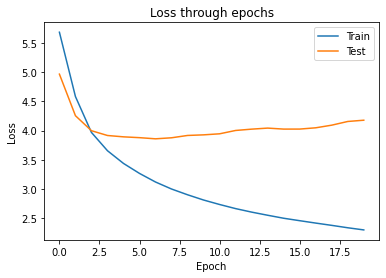

.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................................

In [21]:
vgg_5_256_model = load_eval(f"{drive_folder}/model/vgg_0.5_256/ep007-loss3.118-val_loss3.859.h5",
                            f"{drive_folder}/model/vgg_0.5_256/training.log",
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

### VGG + 256 + Dropout(0.3)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

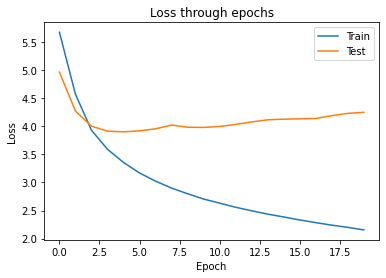

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [24]:
vgg_3_256_model = load_eval(f"{drive_folder}/model/vgg_0.3_256/ep005-loss3.354-val_loss3.898.h5",
                            f"{drive_folder}/model/vgg_0.3_256/training.log",
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

### VGG + 128 + Dropout(0.3)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 128)      970112      input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

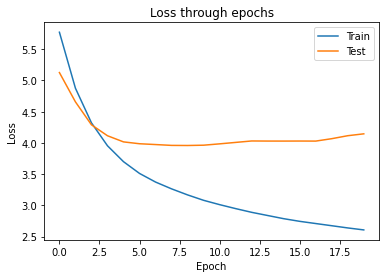

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [25]:
vgg_3_128_model = load_eval(f"{drive_folder}/model/vgg_0.3_128/ep009-loss3.167-val_loss3.959.h5",
                            f"{drive_folder}/model/vgg_0.3_128/training.log",
                            vgg_test_features, test_captions,
                            tokenizer, max_length)

## Inception V3

### Inception V3 + 256 + Dropout(0.5)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
______________________________________________________________________________________________

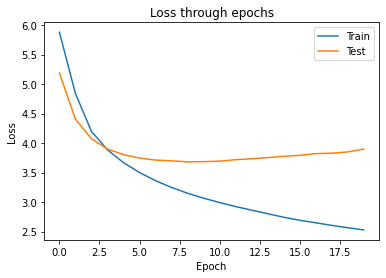

Evaluate model:
.......................................................................................................................................................................................................No. images 200

........................................................................................................................................................................................................No. images 400

........................................................................................................................................................................................................No. images 600

........................................................................................................................................................................................................No. images 800

.........................................................................................................................

In [28]:
inc_5_256_model = load_eval(f"{drive_folder}/model/inc_v3_0.5_256/ep009-loss3.149-val_loss3.681.h5",
                            f"{drive_folder}/model/inc_v3_0.5_256/training.log",
                            inc_test_features, test_captions,
                            tokenizer, max_length)

### Inception V3 + 256 + Dropout(0.3)

In [ ]:
inc_3_256_model = load_eval(f"{drive_folder}/model/inc_v3_0.3_256/ep011-loss2.929-val_loss3.708.h5",
                            f"{drive_folder}/model/inc_v3_0.3_256/training.log",
                            inc_test_features, test_captions,
                            tokenizer, max_length)